In [ ]:
# Import PyTorch libraries
import torch
from torch import nn

# Import visualization library
import matplotlib.pyplot as plt

# Verify PyTorch version
torch.__version__

'2.0.1+cu118'

In [ ]:
# Check to see if we have a GPU to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))

# Print the name of the cuda device, if detected
if device=='cuda':
  print (torch.cuda.get_device_name(device=device))

A cpu device was detected.


In [ ]:
# Use Pandas to do our dataprocessing on the dataset, start by downloading the dataset
import pandas as pd

df = pd.read_csv('phonedata.csv')

# Explore the first 10 rows of the dataset
print(df.head(10))

# Check the size/shape of our dataset
df.shape

   Weekend  Discount  Ratings  High_season  Price  NumberSold
0        1         0        0            1      9          71
1        1         1        1            0     10         137
2        0         1        0            0     10           0
3        1         0        0            1      6         107
4        1         0        0            1      8          80
5        1         1        0            0      6         110
6        1         1        1            0      8         167
7        0         0        1            1      8           0
8        1         0        1            0      8         124
9        1         1        0            0      7          95


(365, 6)

In [ ]:
# Calculate the mean and standard deviation of the price column, then standardize the price column
priceMean = df['Price'].mean()
priceStd = df['Price'].std()
df['Price'] = (df['Price']-priceMean)/priceStd

# Calculate the mean and standard deviation of the numSold column, then standardize numSold
numSoldMean = df['NumberSold'].mean()
numSoldStd = df['NumberSold'].std()
df['NumberSold'] = (df['NumberSold']-numSoldMean)/numSoldStd

In [ ]:
# Create our PyTorch tensors and move to CPU or GPU if available
# Extract the inputs and create a PyTorch tensor x (inputs)
inputs = ['Weekend','Discount','Ratings','High_season','Price']
x = torch.tensor(df[inputs].values,dtype=torch.float, device=device)

# Extract the outputs and create a PyTorch tensor y (outputs)
outputs = ['NumberSold']
y = torch.tensor(df[outputs].values,dtype=torch.float, device=device)

# Explore the first 5 inputs
x[0:5]
# Explore the first 5 outputs
y[0:5]

tensor([[-0.0237],
        [ 0.7437],
        [-0.8492],
        [ 0.3949],
        [ 0.0810]])

In [ ]:
# Define your PyTorch neural network
# Number of Inputs: 5
# Number of Hidden Units: 100
# Number of Hidden Layers: 1
# Activation Function:  Relu
# Number of Outputs: 1

model = nn.Sequential(
            nn.Linear(5,100),
            nn.ReLU(),
            nn.Linear(100,1)
        )

In [ ]:
import torch.optim as optim

# Measure our neural network by mean square error
criterion = torch.nn.MSELoss()

# Train our network with a simple SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train our network a using the entire dataset 5 times
for epoch in range(5):
    totalLoss = 0
    for i in range(len(x)):
       # Single Forward Pass
        ypred = model(x[i])

        # Measure how well the model predicted vs the actual value
        loss = criterion(ypred, y[i])

        # Track how well the model predicted (called loss)
        totalLoss+=loss.item()

        # Update the neural network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print out our loss after each training iteration
    print ("Total Loss: ", totalLoss)

Total Loss:  94.21472778098293
Total Loss:  8.48878577569258
Total Loss:  4.784574268146915
Total Loss:  3.5464918195994244
Total Loss:  3.1372207547670428


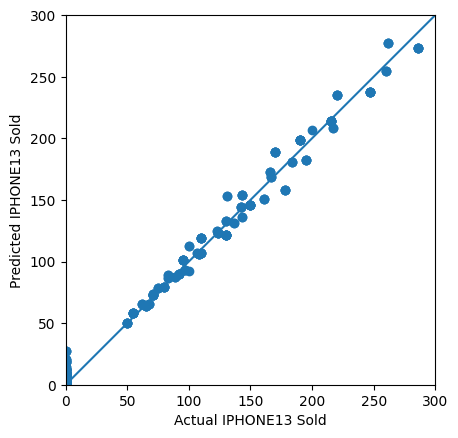

In [ ]:
# Plot predictions vs. true values
@torch.no_grad()
def graphPredictions(model, x, y , minValue, maxValue):
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels

    x.to(device)
    y.to(device)
    model.to(device)

    for i in range(len(x)):
        # Single forward pass
        pred = model(x[i])

        # Un-normalize our prediction
        pred = pred*numSoldStd+numSoldMean
        act = y[i]*numSoldStd+numSoldMean

        # Save prediction and actual label
        predictions.append(pred.tolist())
        actual.append(act.item())

    # Plot actuals vs predictions
    plt.scatter(actual, predictions)
    plt.xlabel('Actual IPHONE13 Sold')
    plt.ylabel('Predicted IPHONE13 Sold')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

graphPredictions(model, x, y, 0, 300)

In [ ]:
# Below we use the synthetic data generator formula to
# determine what the actual result should have been.
def datasetGenerator(weekend, discount, ratings, High_season, price):
    numphonessold = 0
    if weekend:
        numphonessold = (discount*5  + int(500 / price))
        if High_season:
            numphonessold = 1.3 * numphonessold
        if ratings:
            numphonessold = 2 * numphonessold
        if discount:
            numphonessold = 1.25 * numphonessold
    numphonessold = int(numphonessold)

    return numphonessold

# Data that affects the number of phones sold in one day
weekend = 1
discount = 0
ratings = 0
High_season = 1
price = 5

# Calculate what would have been the actual result using
# the synthetic dataset's algorithm
actual = datasetGenerator(weekend, discount, ratings, High_season, price)

# Use the CPU as we just need to do a single pass
model.to('cpu')

# Normalize our inputs using the same values for our training
price = (price - priceMean) / priceStd

# Create our input tensor
x1 = torch.tensor([weekend, discount, ratings, High_season, price],dtype=float)

# Pass the input into the neural network
y1 = model(x1.float())

# Un-normalize our output y1
y1 = y1*numSoldStd+numSoldMean

# Compare what your network predicted to the actual
print ("Neural Network Predicts: ", y1.item())
print ("Actual Result: ", actual)

Neural Network Predicts:  132.7284393310547
Actual Result:  130
